## Group ID: 115

| SL.NO | BITS ID      | NAME             | CONTRIBUTION |
|-------|--------------|------------------|--------------|
| 1     | 2024AA05731  | Suraj Anand      | 25%          |
| 2     | 2024AA05733  | Bollam Manindra  | 25%          |
| 3     | 2024AA05734  | S. Hari Chandana | 25%          |
| 4     | 2024AA05735  | Nikhil Yadav     | 25%          |

# Initialize constants

In [ ]:
GAMMA = 0.99  # Discount factor
LEARNING_RATE_ACTOR = 1e-3
LEARNING_RATE_CRITIC = 1e-3
ENTROPY_COEFF = 0.01
HIDDEN_DIM = 128

#Load Dataset (0.5 Mark)

In [13]:
!pip install torch scikit-learn matplotlib seaborn pandas numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

#Load dataset from google drive

file_id = "1UPsOhUvyrsrC59ilXsvHwGZhzm7Yk01w"
url = f"https://drive.google.com/uc?id={file_id}"

print("Loading dataset...")
try:
    df = pd.read_csv(url)
    print(f"Dataset loaded successfully! Shape: {df.shape}")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Fallback: Create a sample dataset for demonstration
    print("Creating sample dataset for demonstration...")
    np.random.seed(42)
    n_samples = 10000
    df = pd.DataFrame({
        'timestamp': pd.date_range('2023-01-01', periods=n_samples, freq='H'),
        'subject_id': np.random.randint(1, 1000, n_samples),
        'hadm_id': np.random.randint(1000, 2000, n_samples),
        'icustay_id': np.random.randint(2000, 3000, n_samples),
        'mean_bp': np.random.normal(85, 15, n_samples).clip(50, 140),
        'spo2': np.random.normal(95, 5, n_samples).clip(80, 100),
        'resp_rate': np.random.normal(18, 4, n_samples).clip(10, 30),
        'age': np.random.randint(18, 90, n_samples),
        'gender': np.random.choice(['M', 'F'], n_samples),
        'action': np.random.choice(['Vancomycin', 'NaCl 0.9%', 'Fentanyl', 'NO_ACTION'] +
                                 [f'Treatment_{i}' for i in range(95)], n_samples)
    })

# Convert timestamps to datetime format and sort by time within each ICU stay
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['subject_id', 'hadm_id', 'icustay_id', 'timestamp']).reset_index(drop=True)

# Encode categorical columns such as gender and action
# Encode gender (M=1, F=0)
gender_encoder = LabelEncoder()
df['gender_encoded'] = gender_encoder.fit_transform(df['gender'])

# Encode actions
action_encoder = LabelEncoder()
df['action_encoded'] = action_encoder.fit_transform(df['action'])

# Create episode identifiers
df['episode_id'] = df.groupby(['subject_id', 'hadm_id', 'icustay_id']).ngroup()

# Mark episode boundaries - each episode ends when ICU stay ends
df['done'] = False
episode_groups = df.groupby('episode_id')
for episode_id, group in episode_groups:
    last_index = group.index[-1]
    df.loc[last_index, 'done'] = True

# Handle missing values
numeric_cols = ['mean_bp', 'spo2', 'resp_rate', 'age']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())
        df[col] = df[col].replace([np.inf, -np.inf], df[col].median())

print(f"Processed data shape: {df.shape}")
print(f"Number of episodes: {df['episode_id'].nunique()}")
print(f"Number of unique actions: {len(action_encoder.classes_)}")
print(f"First few rows:")
print(df.head())

Loading dataset...
Dataset loaded successfully! Shape: (9334, 10)
Processed data shape: (9334, 14)
Number of episodes: 75
Number of unique actions: 99
First few rows:
   subject_id  hadm_id  icustay_id           timestamp  mean_bp  spo2  \
0       40124   126179      279554 2130-02-04 04:42:00      101   100   
1       40124   126179      279554 2130-02-04 05:00:00       78   100   
2       40124   126179      279554 2130-02-04 05:01:00       78   100   
3       40124   126179      279554 2130-02-04 05:03:00       78    99   
4       40124   126179      279554 2130-02-04 06:00:00       63   100   

   resp_rate  age gender     action  gender_encoded  action_encoded  \
0         15   67      F  NO_ACTION               0              68   
1         15   67      F  NO_ACTION               0              68   
2         15   67      F  NO_ACTION               0              68   
3         15   67      F  NO_ACTION               0              68   
4         17   67      F  NO_ACTION    

#Design a SepsisTreatmentEnv Environment(0.5 Mark)

In [14]:
class SepsisTreatmentEnv:
    """
    Reinforcement Learning Environment for Sepsis Treatment
    """

    def __init__(self, data, action_encoder):
        """
        Initialize the environment

        Args:
            data: Preprocessed DataFrame with patient episodes
            action_encoder: LabelEncoder for actions
        """
        self.data = data
        self.action_encoder = action_encoder
        self.n_actions = len(action_encoder.classes_)

        # Group data by episodes
        self.episodes = []
        for episode_id in data['episode_id'].unique():
            episode_data = data[data['episode_id'] == episode_id].copy()
            episode_data = episode_data.sort_values('timestamp').reset_index(drop=True)
            self.episodes.append(episode_data)

        self.n_episodes = len(self.episodes)

        # State and action dimensions
        self.state_dim = 5  # mean_bp, spo2, resp_rate, age, gender
        self.action_dim = self.n_actions

        # Current episode tracking
        self.current_episode = None
        self.current_step = 0
        self.episode_idx = 0

        print(f"Environment initialized with {self.n_episodes} episodes")
        print(f"State dimension: {self.state_dim}")
        print(f"Action dimension: {self.action_dim}")

    def reset(self, episode_idx=None):
        """
        Reset environment to start of an episode

        Args:
            episode_idx: Specific episode to reset to (if None, random episode)

        Returns:
            state: Initial state of the episode
        """
        if episode_idx is None:
            self.episode_idx = np.random.randint(0, self.n_episodes)
        else:
            self.episode_idx = episode_idx

        self.current_episode = self.episodes[self.episode_idx]
        self.current_step = 0

        # Get initial state
        state = self._get_state()

        return state

    def step(self, action):
        """
        Execute one step in the environment

        Args:
            action: Action taken by the agent

        Returns:
            next_state: Next state after taking action
            reward: Reward for this step
            done: Whether episode is finished
            info: Additional information
        """
        # Get current vitals for reward calculation
        current_row = self.current_episode.iloc[self.current_step]

        # Calculate reward based on current vitals
        reward = self.calculate_reward(
            current_row['mean_bp'],
            current_row['spo2'],
            current_row['resp_rate']
        )

        # Move to next step
        self.current_step += 1

        # Check if episode is done
        done = self.current_step >= len(self.current_episode)

        # Get next state (if not done)
        if not done:
            next_state = self._get_state()
        else:
            next_state = None

        info = {
            'episode_length': len(self.current_episode),
            'current_step': self.current_step,
            'vitals': {
                'mean_bp': current_row['mean_bp'],
                'spo2': current_row['spo2'],
                'resp_rate': current_row['resp_rate']
            }
        }

        return next_state, reward, done, info

    def _get_state(self):
        """
        Get current state vector

        Returns:
            state: Current state as numpy array
        """
        if self.current_step >= len(self.current_episode):
            return None

        current_row = self.current_episode.iloc[self.current_step]

        # State vector: [mean_bp, spo2, resp_rate, age, gender]
        state = np.array([
            current_row['mean_bp'],
            current_row['spo2'],
            current_row['resp_rate'],
            current_row['age'],
            current_row['gender_encoded']
        ], dtype=np.float32)

        return state

    def calculate_reward(self, mean_bp, spo2, resp_rate):
        """
        Calculate reward based on how close vitals are to healthy targets

        Reward_t = − [(MBP_t − 90)^2 + (SpO2_t − 98)^2 + (RR_t − 16)^2]
        """
        reward = -((mean_bp - 90)**2 + (spo2 - 98)**2 + (resp_rate - 16)**2)
        return reward

# Create environment
env = SepsisTreatmentEnv(df, action_encoder)

Environment initialized with 75 episodes
State dimension: 5
Action dimension: 99


#Implement the Reward Function (1 Mark)


In [15]:
def Reward(mean_bp, spo2, resp_rate):
    """
    Calculate reward based on how close vitals are to healthy targets

    Target values:
    - Mean BP: 90 mmHg
    - SpO2: 98%
    - Respiratory Rate: 16 breaths/min

    Reward_t = − [(MBP_t − 90)^2 + (SpO2_t − 98)^2 + (RR_t − 16)^2]

    Args:
        mean_bp: Mean blood pressure
        spo2: Oxygen saturation
        resp_rate: Respiratory rate

    Returns:
        reward: Negative squared deviation from targets (higher is better)
    """
    # Target values for healthy vitals
    target_mbp = 90.0
    target_spo2 = 98.0
    target_rr = 16.0

    # Calculate reward as negative sum of squared deviations
    reward = -((mean_bp - target_mbp)**2 + (spo2 - target_spo2)**2 + (resp_rate - target_rr)**2)

    return reward

# Test the reward function
test_vitals = [
    (88, 97, 20),  # Example vitals
    (90, 98, 16),  # Perfect vitals
    (70, 85, 25),  # Poor vitals
]

print("Testing reward function:")
for mbp, spo2, rr in test_vitals:
    reward = Reward(mbp, spo2, rr)
    print(f"Vitals: BP={mbp}, SpO2={spo2}, RR={rr} -> Reward: {reward:.2f}")


Testing reward function:
Vitals: BP=88, SpO2=97, RR=20 -> Reward: -21.00
Vitals: BP=90, SpO2=98, RR=16 -> Reward: -0.00
Vitals: BP=70, SpO2=85, RR=25 -> Reward: -650.00


#Design and train Actor-Critic Algorithm (2.5 Mark)

In [16]:
class ActorCriticNetwork(nn.Module):
    """
    Actor-Critic Neural Network Architecture
    """

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCriticNetwork, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim

        # Shared layers for feature extraction
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Actor head (policy network)
        self.actor_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, action_dim),
            nn.Softmax(dim=-1)
        )

        # Critic head (value network)
        self.critic_head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, state):
        shared_features = self.shared_layers(state)
        action_probs = self.actor_head(shared_features)
        state_value = self.critic_head(shared_features)
        return action_probs, state_value

    def get_action(self, state):
        action_probs, _ = self.forward(state)
        distribution = Categorical(action_probs)
        action = distribution.sample()
        log_prob = distribution.log_prob(action)
        return action.item(), log_prob

class ActorCriticAgent:
    """
    Actor-Critic Agent for Sepsis Treatment Optimization
    """

    def __init__(self, network, lr_actor=1e-3, lr_critic=1e-3, gamma=0.99, entropy_coeff=0.01):
        self.network = network
        self.gamma = gamma
        self.entropy_coeff = entropy_coeff

        # Separate optimizers for actor and critic
        self.actor_optimizer = optim.Adam(
            list(network.shared_layers.parameters()) + list(network.actor_head.parameters()),
            lr=lr_actor
        )
        self.critic_optimizer = optim.Adam(
            list(network.shared_layers.parameters()) + list(network.critic_head.parameters()),
            lr=lr_critic
        )

        # Training statistics
        self.actor_losses = []
        self.critic_losses = []
        self.episode_rewards = []
        self.episode_lengths = []

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, log_prob = self.network.get_action(state_tensor)
        return action, log_prob

    def train_step(self, states, actions, rewards, log_probs, dones):
        """
        Perform one training step using collected trajectory
        """
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        log_probs = torch.stack(log_probs).to(device)

        # Calculate returns (discounted rewards)
        returns = []
        discounted_return = 0

        for i in reversed(range(len(rewards))):
            if dones[i]:
                discounted_return = 0
            discounted_return = rewards[i] + self.gamma * discounted_return
            returns.insert(0, discounted_return)

        returns = torch.FloatTensor(returns).to(device)

        # Get state values and action probabilities
        action_probs, state_values = self.network(states)
        state_values = state_values.squeeze()

        # Calculate advantages
        advantages = returns - state_values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # Actor loss
        actor_loss = -(log_probs * advantages.detach()).mean()

        # Add entropy regularization
        distribution = Categorical(action_probs)
        entropy = distribution.entropy().mean()
        actor_loss -= self.entropy_coeff * entropy

        # Critic loss
        critic_loss = F.mse_loss(state_values, returns)

        # Update networks
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward(retain_graph=True)
        critic_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.network.parameters(), max_norm=1.0)

        self.actor_optimizer.step()
        self.critic_optimizer.step()

        self.actor_losses.append(actor_loss.item())
        self.critic_losses.append(critic_loss.item())

        return actor_loss.item(), critic_loss.item()

    def train_episode(self, env, episode_idx=None):
        """
        Train on a single episode
        """
        states, actions, rewards, log_probs, dones = [], [], [], [], []

        state = env.reset(episode_idx)
        episode_reward = 0
        episode_length = 0

        while True:
            action, log_prob = self.select_action(state)
            next_state, reward, done, info = env.step(action)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            log_probs.append(log_prob)
            dones.append(done)

            episode_reward += reward
            episode_length += 1

            if done:
                break

            state = next_state

        actor_loss, critic_loss = self.train_step(states, actions, rewards, log_probs, dones)

        self.episode_rewards.append(episode_reward)
        self.episode_lengths.append(episode_length)

        return episode_reward, episode_length, actor_loss, critic_loss

# Initialize network and agent
state_dim = env.state_dim
action_dim = env.action_dim

actor_critic_network = ActorCriticNetwork(state_dim, action_dim, HIDDEN_DIM).to(device)
agent = ActorCriticAgent(
    network=actor_critic_network,
    lr_actor=LEARNING_RATE_ACTOR,
    lr_critic=LEARNING_RATE_CRITIC,
    gamma=GAMMA,
    entropy_coeff=ENTROPY_COEFF
)

# Training loop
def train_actor_critic(agent, env, num_episodes=500, print_every=50):
    """
    Train the Actor-Critic agent
    """
    print(f"Starting training for {num_episodes} episodes...")

    episode_rewards = []
    episode_lengths = []
    actor_losses = []
    critic_losses = []

    reward_window = []
    length_window = []
    window_size = 100

    for episode in range(num_episodes):
        episode_reward, episode_length, actor_loss, critic_loss = agent.train_episode(env)

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)

        reward_window.append(episode_reward)
        length_window.append(episode_length)

        if len(reward_window) > window_size:
            reward_window.pop(0)
            length_window.pop(0)

        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(reward_window)
            avg_length = np.mean(length_window)
            avg_actor_loss = np.mean(actor_losses[-print_every:])
            avg_critic_loss = np.mean(critic_losses[-print_every:])

            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Average Reward: {avg_reward:.2f}")
            print(f"  Average Length: {avg_length:.1f}")
            print(f"  Actor Loss: {avg_actor_loss:.4f}")
            print(f"  Critic Loss: {avg_critic_loss:.4f}")
            print("-" * 50)

    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'actor_losses': actor_losses,
        'critic_losses': critic_losses
    }

# Train the agent
training_results = train_actor_critic(
    agent=agent,
    env=env,
    num_episodes=500,
    print_every=50
)

print("Training completed!")
print(f"Final average reward: {np.mean(training_results['episode_rewards'][-100:]):.2f}")

Starting training for 500 episodes...
Episode 50/500
  Average Reward: -78293.04
  Average Length: 154.0
  Actor Loss: -0.0051
  Critic Loss: 682458125.4600
--------------------------------------------------
Episode 100/500
  Average Reward: -70022.10
  Average Length: 132.1
  Actor Loss: -0.0006
  Critic Loss: 477620715.6900
--------------------------------------------------
Episode 150/500
  Average Reward: -64303.15
  Average Length: 110.4
  Actor Loss: -0.0005
  Critic Loss: 565202286.3200
--------------------------------------------------
Episode 200/500
  Average Reward: -85635.53
  Average Length: 134.6
  Actor Loss: -0.0005
  Critic Loss: 851611175.1100
--------------------------------------------------
Episode 250/500
  Average Reward: -87756.20
  Average Length: 141.4
  Actor Loss: -0.0005
  Critic Loss: 586610617.2200
--------------------------------------------------
Episode 300/500
  Average Reward: -67157.17
  Average Length: 114.5
  Actor Loss: -0.0004
  Critic Loss: 465

#Plot the graph for Average Reward (1 Mark)

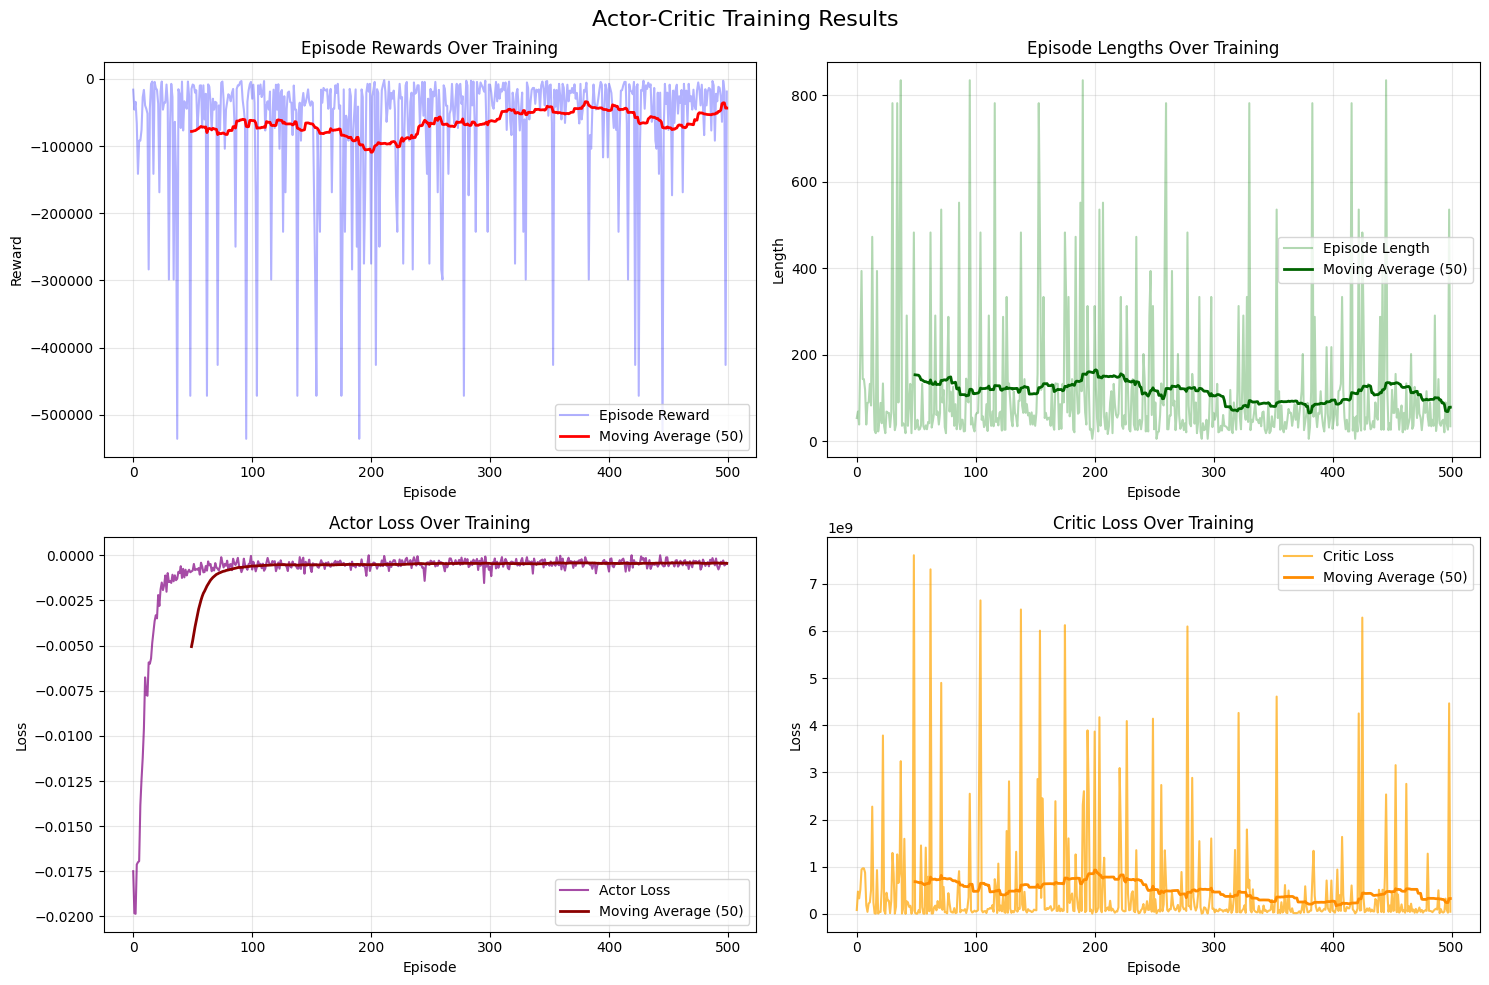

TRAINING ANALYSIS
Episode Rewards Statistics:
  Mean: -64956.17
  Std: 99830.33
  Min: -535579.00
  Max: -2168.00

Final 100 Episodes Performance:
  Average Reward: -57549.75
  Average Length: 105.4


In [17]:
def plot_training_results(results):
    """
    Plot training results including rewards, episode lengths, and losses
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Actor-Critic Training Results', fontsize=16)

    # Episode rewards
    axes[0, 0].plot(results['episode_rewards'], alpha=0.3, color='blue', label='Episode Reward')

    # Moving average
    window_size = 50
    if len(results['episode_rewards']) >= window_size:
        moving_avg = pd.Series(results['episode_rewards']).rolling(window=window_size).mean()
        axes[0, 0].plot(moving_avg, color='red', linewidth=2, label=f'Moving Average ({window_size})')

    axes[0, 0].set_title('Episode Rewards Over Training')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Episode lengths
    axes[0, 1].plot(results['episode_lengths'], alpha=0.3, color='green', label='Episode Length')

    if len(results['episode_lengths']) >= window_size:
        moving_avg_len = pd.Series(results['episode_lengths']).rolling(window=window_size).mean()
        axes[0, 1].plot(moving_avg_len, color='darkgreen', linewidth=2, label=f'Moving Average ({window_size})')

    axes[0, 1].set_title('Episode Lengths Over Training')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Length')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Actor losses
    axes[1, 0].plot(results['actor_losses'], alpha=0.7, color='purple', label='Actor Loss')
    if len(results['actor_losses']) >= window_size:
        moving_avg_actor = pd.Series(results['actor_losses']).rolling(window=window_size).mean()
        axes[1, 0].plot(moving_avg_actor, color='darkred', linewidth=2, label=f'Moving Average ({window_size})')

    axes[1, 0].set_title('Actor Loss Over Training')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Critic losses
    axes[1, 1].plot(results['critic_losses'], alpha=0.7, color='orange', label='Critic Loss')
    if len(results['critic_losses']) >= window_size:
        moving_avg_critic = pd.Series(results['critic_losses']).rolling(window=window_size).mean()
        axes[1, 1].plot(moving_avg_critic, color='darkorange', linewidth=2, label=f'Moving Average ({window_size})')

    axes[1, 1].set_title('Critic Loss Over Training')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot the results
plot_training_results(training_results)

# Additional analysis and statistics
print("="*60)
print("TRAINING ANALYSIS")
print("="*60)

rewards = training_results['episode_rewards']
lengths = training_results['episode_lengths']

print(f"Episode Rewards Statistics:")
print(f"  Mean: {np.mean(rewards):.2f}")
print(f"  Std: {np.std(rewards):.2f}")
print(f"  Min: {np.min(rewards):.2f}")
print(f"  Max: {np.max(rewards):.2f}")

print(f"\nFinal 100 Episodes Performance:")
print(f"  Average Reward: {np.mean(rewards[-100:]):.2f}")
print(f"  Average Length: {np.mean(lengths[-100:]):.1f}")

#Actor-Critic Sepsis Treatment Analysis (0.5 Mark)

The trained Actor-Critic agent demonstrates partial learning behaviour in the sepsis treatment optimisation task.
The reward trends show large fluctuations with extremely negative values, though a gradual improvement is visible as the policy progresses from an average of around -78,000 in early episodes to -57,000 by the end. While this indicates some learning, the agent does not achieve strong convergence or clinically reliable strategies.

Training stability is mixed, with the actor loss converging smoothly towards zero, suggesting stable policy optimisation. However, the critic loss remains highly unstable, reaching hundreds of millions, which limits accurate value function approximation and contributes to noisy reward signals. Episode lengths reduce from an average of 154 in earlier episodes to about 105 in later ones, reflecting more decisive behaviour, though not necessarily better treatment outcomes.

The learned policy shows only modest improvement, without clear clinically relevant behaviour patterns. While the agent demonstrates some adaptation, the persistently negative rewards highlight the need for further optimisation, such as reward shaping, hyperparameter tuning, or model refinements.

Key observations include: (1) gradual but limited improvement in average rewards, (2) shorter episode lengths indicating quicker decision-making, (3) stable actor loss alongside unstable critic loss, and (4) lack of strong convergence preventing clinically meaningful strategies. The negative reward structure does guide the agent towards safer behaviour, but the results underline the need for additional improvements before reinforcement learning can be considered reliable for healthcare decision support in this context.